### 0.1 Import libraries

In [269]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

### 0.2 Load data

In [270]:
# reading the csv dataset into Pandas DataFrame
data = pd.read_csv('dataset/train.csv')

# split into train and test
train, test = train_test_split(data, test_size=0.2)

## 1. Data preparation:
* Exploration (EDA) & Visualizaiton
* Cleaning
* Wrangling & Feature Engineering

### 1.1 Exploration (EDA) & Visualizaiton

#### General info about data

In [271]:
train.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
67854,10615357,5.164786,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",2,1.0,Real Bed,moderate,True,...,40.659165,-73.991369,"Quiet South Slope house w/ piano, porch & garden.",Greenwood Heights,12,95.0,https://a0.muscache.com/im/pictures/5e7dc6b9-d...,11215,1.0,1.0
29796,497810,4.828314,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",4,1.0,Real Bed,strict,True,...,40.843045,-73.940452,Spacious & Trendy Uptown Apartment,Washington Heights,10,100.0,https://a0.muscache.com/im/pictures/107165611/...,10032,1.0,2.0
22202,17460467,5.857933,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",Kitchen,""Hot ...",4,1.0,Real Bed,strict,True,...,37.775852,-122.426412,"Spacious, convenient, comfortable.",Hayes Valley,45,96.0,https://a0.muscache.com/im/pictures/78098462/f...,94102.0,2.0,2.0
34519,21119368,5.416100,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",9,3.0,Real Bed,moderate,True,...,38.886101,-76.947436,Washington DC's Finest: 4 bdrms+house 1-9 Persons,Fort Dupont,8,95.0,https://a0.muscache.com/im/pictures/6074c82a-a...,20019,4.0,5.0
71106,13414367,5.293305,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",4,2.0,Real Bed,strict,True,...,34.060648,-118.290646,5-STAR LA 2BED/2BATH HIGHRISE + BREATHTAKING ...,Westlake,42,95.0,https://a0.muscache.com/im/pictures/dfa34fe0-b...,90010,2.0,2.0


In [272]:
len(train), len(test)

(59288, 14823)

In [273]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

##### General statistic information

In [274]:
train.describe()

,id,log_price,accommodates,bathrooms,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
count,5.928800e+04,59288.000000,59288.000000,59132.000000,59288.000000,59288.000000,59288.000000,45803.000000,59224.000000,59179.000000
mean,1.127080e+07,4.783246,3.153943,1.236505,38.442168,-92.397081,20.942771,94.088138,1.265602,1.709069
std,6.077906e+06,0.719463,2.148092,0.583623,3.078522,21.700132,38.023271,7.793962,0.849558,1.246063
min,3.440000e+02,0.000000,1.000000,0.000000,33.338905,-122.511500,0.000000,20.000000,0.000000,0.000000
25%,6.269566e+06,4.317488,2.000000,1.000000,34.128288,-118.342848,1.000000,92.000000,1.000000,1.000000
50%,1.224590e+07,4.718499,2.000000,1.000000,40.661317,-76.998125,6.000000,96.000000,1.000000,1.000000
75%,1.640540e+07,5.220356,4.000000,1.000000,40.745732,-73.954811,24.000000,100.000000,1.000000,2.000000
max,2.122797e+07,7.600402,16.000000,8.000000,42.390437,-70.985047,605.000000,100.000000,10.000000,18.000000


#### Data operations

In [275]:
binary_variables = ['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']

categorical_variables = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city',
                         'neighbourhood', 'amenities']

numeric_variables = ['log_price', 'accommodates', 'bathrooms', 'host_response_rate', 'latitude', 'longitude',
                     'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds']  

column_to_drop = ['id', 'name', 'thumbnail_url', 'zipcode', 'description', 'first_review',
                  'host_since', 'last_review']

columns = {'binary_variables': binary_variables, 'categorical_variables': categorical_variables,
           'numeric_variables': numeric_variables, 'column_to_drop': column_to_drop, 'binned_variables': []}

#### Histograms

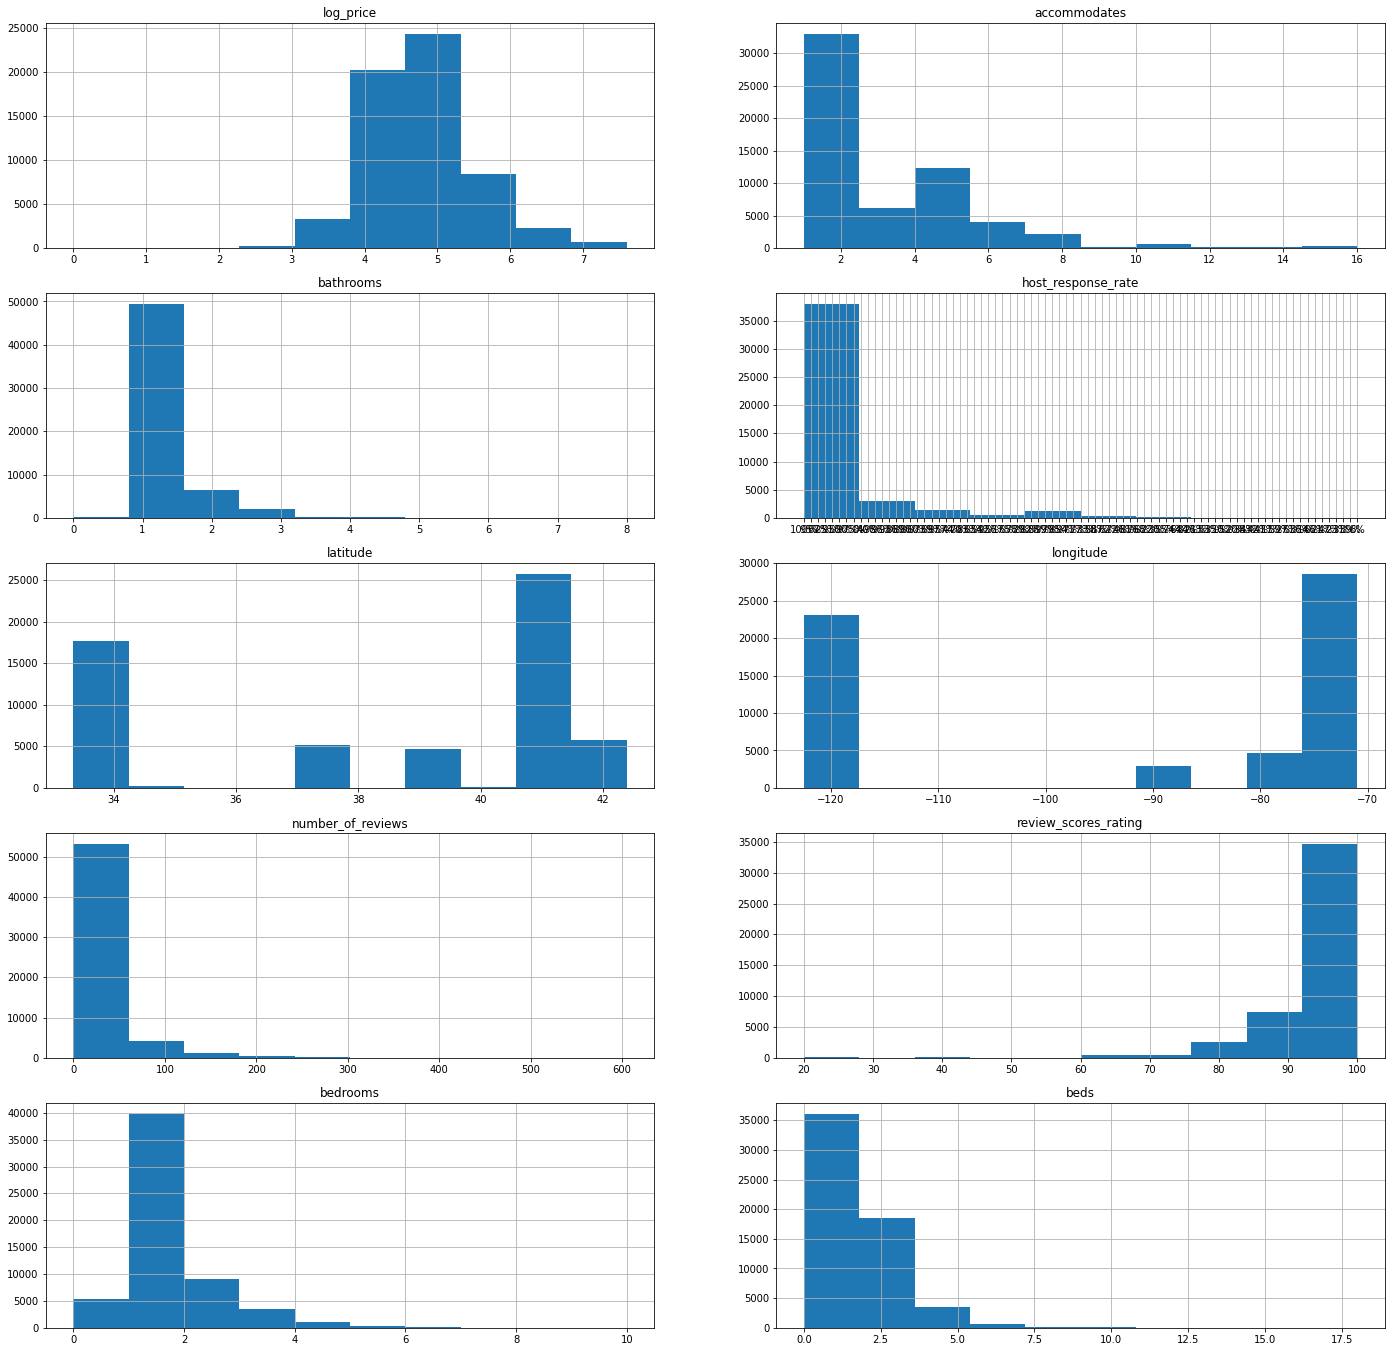

In [276]:
#initialize a Matplotlib figures grid
fig, axes = plt.subplots(5, 2,figsize=(24,24))

#generate a histogram using Pandas, for each numeric variable
for i in range(5):
    for j in range(2):
        var = numeric_variables[i*2+j]
        train[var].hist(ax=axes[i,j])
        axes[i,j].set_title(var)


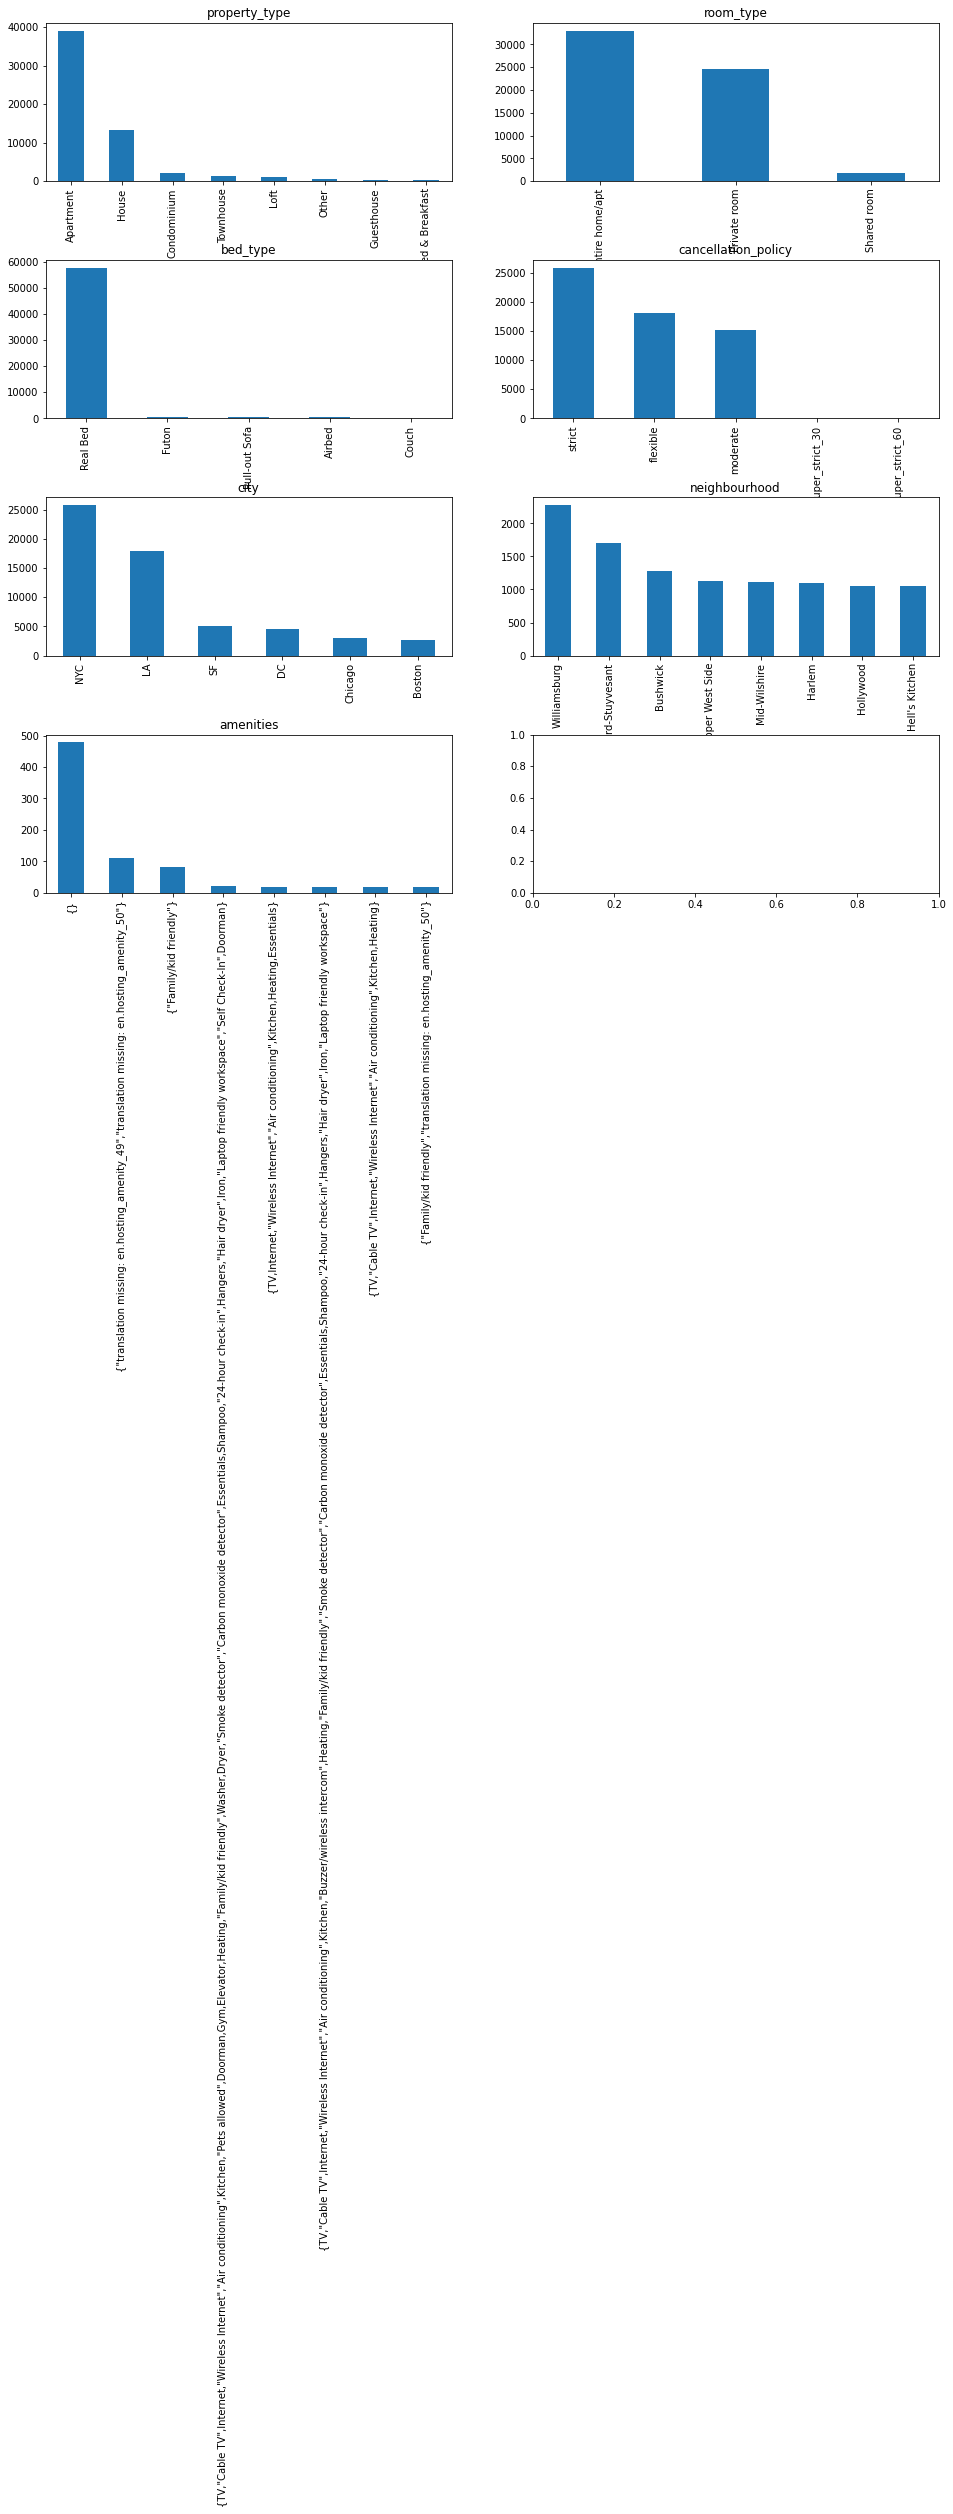

In [277]:
#generate a figures grid:
fig, axes = plt.subplots(4,2,figsize=(16,16))
fig.subplots_adjust(hspace=0.5)

#we will create a histogram for each categorical attribute
n=len(categorical_variables)
num_rows = 2
max_bars = 8

for i,variable in enumerate(categorical_variables):
    #calculate the current place on the grid
    r=int(i/num_rows)
    c=i%num_rows
    
    #create the "value counts" for the first <max_bars> categories:
    u=min(train[variable].nunique(),max_bars)
    vc = train[variable].value_counts()[:u]
    
    # plot a bar chart using Pandas
    vc.plot(kind='bar',ax=axes[r,c],title=variable)

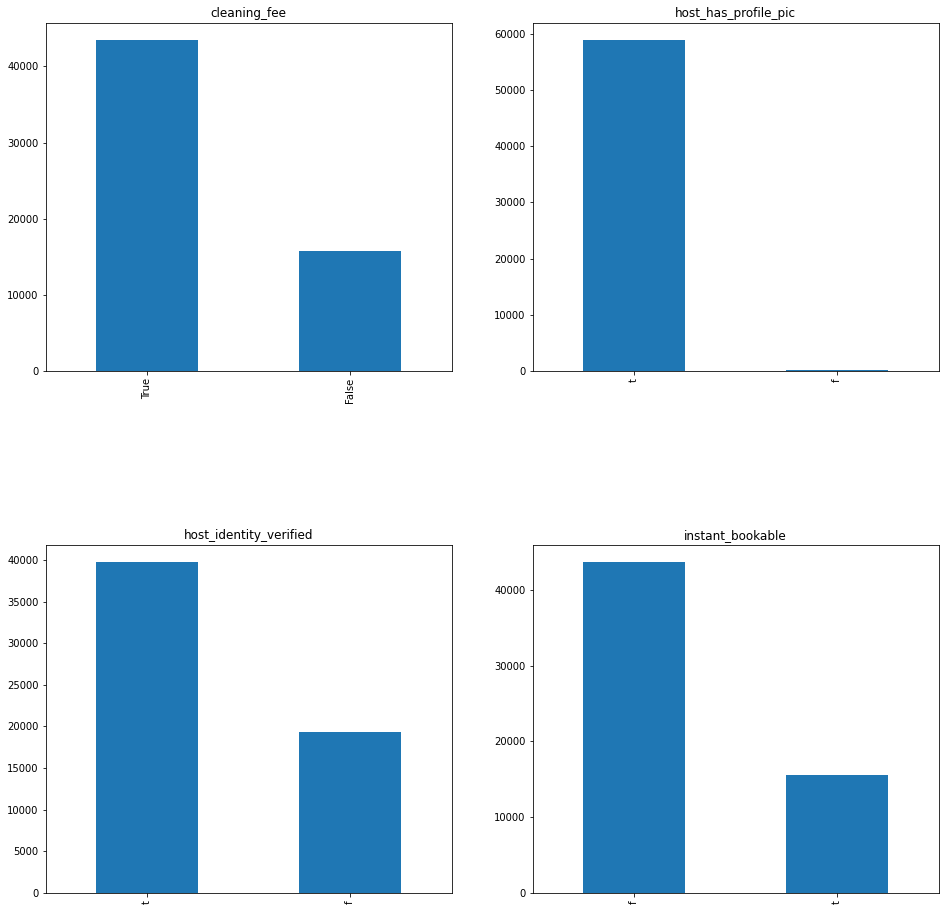

In [278]:
#generate a figures grid:
fig, axes = plt.subplots(2,2,figsize=(16,16))
fig.subplots_adjust(hspace=0.5)

#we will create a histogram for each categorical attribute
n=len(binary_variables)
num_rows = 2
max_bars = 8

for i,variable in enumerate(binary_variables):
    #calculate the current place on the grid
    r=int(i/num_rows)
    c=i%num_rows
    
    #create the "value counts" for the first <max_bars> categories:
    u=min(train[variable].nunique(),max_bars)
    vc = train[variable].value_counts()[:u]
    
    # plot a bar chart using Pandas
    vc.plot(kind='bar',ax=axes[r,c],title=variable)

##### Correlations

<AxesSubplot:>

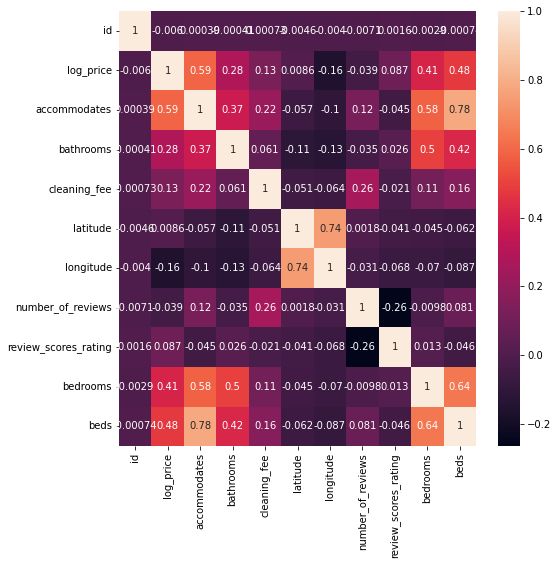

In [279]:
plt.figure(figsize=(8,8))
sns.heatmap(train.corr(method='spearman'), annot=True)
# TODO feature class correlation

In [280]:
# Count nan values
len(train) - train.count()

id                            0
log_price                     0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                   156
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
description                   0
first_review              12801
host_has_profile_pic        151
host_identity_verified      151
host_response_rate        14649
host_since                  151
instant_bookable              0
last_review               12772
latitude                      0
longitude                     0
name                          0
neighbourhood              5468
number_of_reviews             0
review_scores_rating      13485
thumbnail_url              6584
zipcode                     744
bedrooms                     64
beds                        109
dtype: int64

#### Number of unique values

In [281]:
for var in binary_variables:
    print(var, len(train[var].unique()))

for var in categorical_variables:
    print(var, len(train[var].unique()))

for var in numeric_variables:
    print(var, len(train[var].unique()))

cleaning_fee 2
host_has_profile_pic 3
host_identity_verified 3
instant_bookable 2
property_type 35
room_type 3
bed_type 5
cancellation_policy 5
city 6
neighbourhood 608
amenities 54283
log_price 721
accommodates 16
bathrooms 18
host_response_rate 80
latitude 59288
longitude 59288
number_of_reviews 360
review_scores_rating 54
bedrooms 12
beds 19


### 1.2 Cleaning

#### Drop Unnecessary Column


In [282]:
for column in columns['column_to_drop']:
    train = train.drop(column, axis=1)
    test = test.drop(column, axis=1)

#### Type Conversion


Boolean Variables hendling



In [283]:
for column in columns['binary_variables']:
    train[column] = train[column].apply(lambda x: True if x == 'TRUE' or x == 't' else False)
    test[column] = test[column].apply(lambda x: True if x == 'TRUE' or x == 't' else False)


Numeric Variables to Float


In [284]:
train['host_response_rate'] = train['host_response_rate'].str.rstrip('%').astype('float') / 100.0
test['host_response_rate'] = test['host_response_rate'].str.rstrip('%').astype('float') / 100.0

In [285]:
for column in columns['numeric_variables']:
    train[column] = train[column].astype(float)
    test[column] = test[column].astype(float)

#### Impute Missing Values

In [286]:
null_columns = []
for column in columns['binary_variables'] + columns['categorical_variables'] + columns['numeric_variables']:
    if train[column].isnull().sum():
        null_columns.append(column)
    if test[column].isnull().sum():
        null_columns.append(column)

In [287]:
train_with_most_frequent_values = train.copy()
test_with_most_frequent_values = test.copy()
for column in null_columns:
    val = train_with_most_frequent_values[column].value_counts().index[0]
    train_with_most_frequent_values[column] = train_with_most_frequent_values[column].fillna(val)
    test_with_most_frequent_values[column] = test_with_most_frequent_values[column].fillna(val)

train = train_with_most_frequent_values
test = test_with_most_frequent_values

#### Reset Indexes


In [288]:
train = train.reset_index()
test = test.reset_index()

### 1.3 Wrangling & Feature Engineering


#### amenities

In [289]:
def collect_amenities(data, columns_dict):
    chars_to_remove = '"{}'
    amenities_set = set()
    for line in data['amenities']:
        amenities = line.split(',')
        for obj in amenities:
            for char in chars_to_remove:
                obj = obj.replace(char, "")
            if "translation missing" not in obj and obj != '':
                amenities_set.add(obj)
    for amenity in amenities_set:
        columns_dict['binary_variables'].append(amenity)
    return list(amenities_set)


def create_amenities_array(amenities_list, data):
    amenities_array = []
    for index, row in data.iterrows():
        array = np.zeros(shape=(len(amenities_list)))
        row_amen = data['amenities'][index].split(',')
        for amen in row_amen:
            item = amen.replace('"', '').replace('}', '').replace('{', '')
            if item in amenities_list:
                res = amenities_list.index(item)
                array[res] = 1
        amenities_array.append(array.tolist())

    amenities_df = pd.DataFrame(amenities_array, columns=amenities_list)
    return amenities_df


# converting amenities column to binary columns and updating columns_dict
def create_amenities_cols(data, amenities_set):
    amenities_array = create_amenities_array(amenities_set, data)

    data = data.drop(['amenities'], axis=1)
    data = pd.concat([data, amenities_array], axis=1)

    return data

In [290]:
amenities_list = collect_amenities(train, columns)
train = create_amenities_cols(train, amenities_list)
test = create_amenities_cols(test, amenities_list)
columns['categorical_variables'].remove('amenities')

#### neighbourhood

In [291]:
top_neighbourhoods = train['neighbourhood'].value_counts().head(50).keys()
for index, row in train.iterrows():
    if row['neighbourhood'] not in top_neighbourhoods:
        train.at[index,'neighbourhood'] = 'other'
for index, row in test.iterrows():
    if row['neighbourhood'] not in top_neighbourhoods:
        test.at[index,'neighbourhood'] = 'other'

#### one hot encoding gor categorical variables

In [292]:
# we leave the target feature as is
oh_train = train['log_price']
oh_test = test['log_price']

# now adding the one hot encoded data
for variable in columns['binned_variables']+columns['categorical_variables']:
    onehot_train_col = pd.get_dummies(train[variable], prefix=variable)
    oh_train = pd.concat([oh_train, onehot_train_col], axis=1)

    onehot_test_col = pd.get_dummies(test[variable], prefix=variable)
    oh_test = pd.concat([oh_test, onehot_test_col], axis=1)

#### concatenating binary variables 

In [293]:
for col in columns['binary_variables']:
    train[col] = train[col].replace(True, 1)
    train[col] =train[col].replace(False, 0)
    oh_train = pd.concat([oh_train, train[col]], axis=1)

    test[col] = test[col].replace(True, 1)
    test[col] = test[col].replace(False, 0)
    oh_test = pd.concat([oh_test, test[col]], axis=1)

#### concatenating numeric variables

In [294]:
for col in columns['numeric_variables']:
    if col != 'log_price':
        oh_train = pd.concat([oh_train, train[col]], axis=1)

        oh_test = pd.concat([oh_test, test[col]], axis=1)

#### equalize cloumns

In [295]:
add_to_test = list(set(oh_train.columns) - set(oh_test.columns))
add_to_train = list(set(oh_test.columns) - set(oh_train.columns))
for col in add_to_train:
    oh_train[col] = 0
for col in add_to_test:
    oh_test[col] = 0

oh_test = oh_test[oh_train.columns]

d:\users\liels\onedrive\desktop\airbnbprice\venv\lib\site-packages\ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


## 2. Train Model: Logistic regression

In [296]:
linear_regression = linear_model.LinearRegression()
train_class = oh_train['log_price']
oh_train_data = oh_train.drop('log_price', axis=1)
# train the model:
linear_regression.fit(oh_train_data, train_class)
print(linear_regression)

LinearRegression()


## 3. Evaluate results

#### separate the train and test to examples and labels and predict the test result

In [298]:
train_y = oh_train['log_price'].values
train_x = oh_train.drop('log_price', axis=1)
test_y = oh_test['log_price'].values
test_x = oh_test.drop('log_price', axis=1)

prediction_test = linear_regression.predict(test_x)

##### printing the error

In [299]:
r2 = r2_score(test_y, prediction_test)
print('r2 score:', r2)

print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):",
      "{:,.3f}".format(mean_absolute_percentage_error(test_y, prediction_test)))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.3f}".format(mean_absolute_error(test_y, prediction_test)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.3f}".
      format(np.sqrt(mean_squared_error(test_y, prediction_test))))


r2 score: 0.642046914955942
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.066
Mean Absolute Error (Σ|y-pred|/n): 0.313
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0.424


#### residuals between the real label and test label

In [300]:
residuals = test_y - prediction_test
max_error = max(prediction_test) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(
    residuals).index(min(residuals))
max_true, max_pred = test_y[max_idx], prediction_test[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

Max Error: -3


#### real values vs. predicted values plot.

Text(0.5, 1.0, 'true values against the predicted values')

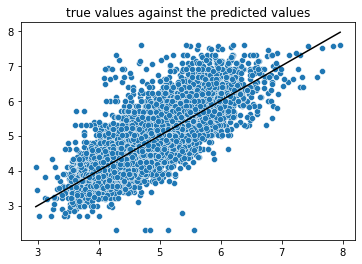

In [301]:
sns.scatterplot(x=prediction_test, y=test_y)
sns.lineplot(x=prediction_test, y=prediction_test, color='black')
plt.title('true values against the predicted values')


Text(0.5, 1.0, 'Residuals (%)')

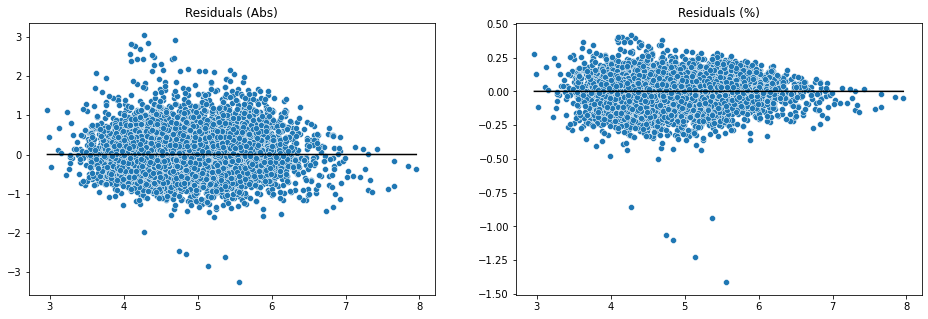

In [302]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.scatterplot(x=prediction_test, y=residuals, ax=ax[0])
sns.lineplot(x=prediction_test, y=0, ax=ax[0], color='black')
ax[0].set_title("Residuals (Abs)")
sns.scatterplot(x=prediction_test, y=residuals / test_y, ax=ax[1])
sns.lineplot(x=prediction_test, y=0, ax=ax[1], color='black')
ax[1].set_title("Residuals (%)")

In [303]:
rel_res = residuals / test_y

rel_res = abs(rel_res)
print(len(rel_res[rel_res < 0.05]) / len(rel_res))
print(len(rel_res[rel_res > 0.2]) / len(rel_res))



0.4951089523038521
0.03332658706064899


Text(0.5, 1.0, 'Prediction and real')

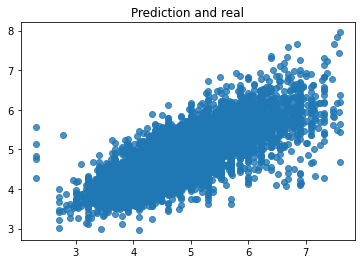

In [304]:
sns.regplot(x=test_y, y=prediction_test, fit_reg=False)
plt.title('Prediction and real')


d:\users\liels\onedrive\desktop\airbnbprice\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Error variance')

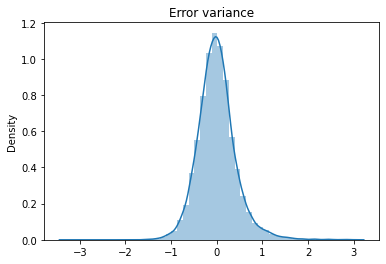

In [305]:
sns.distplot(test_y - prediction_test, bins=50)
plt.title('Error variance')